In [1]:
import torch
import timm
import backbone
import anchor
import importlib
import dataset
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2




c:\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Python\Python313\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
importlib.reload(dataset)

image_dir = "dataset\\image\\"
label_dir = "dataset\\label\\"
classes = {0:'background',1:'NG',2:'OK'}

image_test =dataset.ListDataset(image_dir,label_dir,classes,transform=True)

train_transform = A.Compose([
    A.RandomSizedBBoxSafeCrop(width=450,height=450,erosion_rate=0.8),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.2),
], bbox_params=A.BboxParams(format='yolo', # Specify input format
                           label_fields=['class_labels'] # Specify label argument name(s)
                           ))

final_transform = A.Compose([
    A.AdditiveNoise(noise_type="gaussian",
                    spatial_mode="constant",
                    noise_params={"mean_range": (0.0, 0.0), "std_range": (0.05, 0.15)}),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1.0),
    A.Affine(translate_percent={'x': (-0.2, 0.2), 'y': (-0.2, 0.2)},  # x축 10~20%, y축 -20~20% 랜덤 이동
             p=0.3),
    A.Affine(rotate = (-20,20), p = 0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', # Specify input format
                           label_fields=['class_labels'] # Specify label argument name(s)
                           ))

aug_para ={"alpha":0.7,"lambda":0.7,"prob":0.5}


image_test.add_agumentation(train_transform,aug_para,final_transform)

set_size = len(image_test)
train_dataset_size = int(0.8*set_size)
test_dataset_size = set_size-train_dataset_size
print("set size: {0}, test_set size : {1}".format(train_dataset_size,test_dataset_size))

train_indces, valid_indces = torch.utils.data.random_split(range(set_size), [train_dataset_size, test_dataset_size])
print("set size: {0}, test_set size : {1}".format(train_dataset_size,test_dataset_size))

result = image_test[1]

train_dataset = torch.utils.data.Subset(image_test, train_indces)
valid_dataset = torch.utils.data.Subset(image_test, train_indces)

batch_size = 10
num_workers = 1

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               num_workers=num_workers,
                                               collate_fn = image_test.collate_fn)

print("len of train_loader: {0}".format(len(train_dataloader)))
image, loc, class_target = next(iter(train_dataloader))

'''
print(result["image"].shape)
print(result["image"].dtype)
print(result["bboxes"])
print(result["class_label"])

img = result["image"]
result_label = result["class_label"]

for i, box in enumerate(result["bboxes"]):
    x_center, y_center, w, h = box
    x1 = int((x_center - w/2) * 450)
    y1 = int((y_center - h/2) * 450)
    x2 = int((x_center + w/2) * 450)
    y2 = int((y_center + h/2) * 450)
    if result_label[i] == 1:
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
    else:
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
plt.imshow(img)
plt.xticks([]); plt.yticks([])
plt.show()
'''

set size: 1084, test_set size : 272
set size: 1084, test_set size : 272
<class 'dict'>
len of train_loader: 109


error: Caught error in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Python\Python313\Lib\site-packages\torch\utils\data\_utils\worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "c:\Python\Python313\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
  File "c:\Python\Python313\Lib\site-packages\torch\utils\data\dataset.py", line 420, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Hellboy_KIM\Documents\GitHub\Yolo-V4-scratch\dataset.py", line 88, in __getitem__
    result = self.finish_aug(image=result['image'],bboxes=result['bboxes'],class_labels=result['class_labels'])
  File "c:\Python\Python313\Lib\site-packages\albumentations\core\composition.py", line 496, in __call__
    data = t(**data)
  File "c:\Python\Python313\Lib\site-packages\albumentations\core\transforms_interface.py", line 176, in __call__
    return self.apply_with_params(params, **kwargs)
           ~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^
  File "c:\Python\Python313\Lib\site-packages\albumentations\core\transforms_interface.py", line 200, in apply_with_params
    target_function(ensure_contiguous_output(arg), **params),
    ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python\Python313\Lib\site-packages\albumentations\augmentations\transforms.py", line 5581, in apply
    return fmain.add_noise(img, noise_map)
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^
  File "c:\Python\Python313\Lib\site-packages\albucore\utils.py", line 115, in wrapped_function
    result = func(img, *args, **kwargs)
  File "c:\Python\Python313\Lib\site-packages\albumentations\augmentations\functional.py", line 1946, in add_noise
    return add(img, noise, inplace=False)
  File "c:\Python\Python313\Lib\site-packages\albucore\functions.py", line 271, in add
    return add_vector(img, value, inplace) if value.ndim == 1 else add_array(img, value, inplace)
           ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python\Python313\Lib\site-packages\albucore\utils.py", line 115, in wrapped_function
    result = func(img, *args, **kwargs)
  File "c:\Python\Python313\Lib\site-packages\albucore\functions.py", line 250, in add_vector
    return add_opencv(img, value, inplace)
  File "c:\Python\Python313\Lib\site-packages\albucore\decorators.py", line 42, in wrapped_function
    result = func(img, *args, **kwargs)
  File "c:\Python\Python313\Lib\site-packages\albucore\functions.py", line 230, in add_opencv
    return cv2.add(img, value, dst=dst)
           ~~~~~~~^^^^^^^^^^^^^^^^^^^^^
cv2.error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:689: error: (-5:Bad argument) When the input arrays in add/subtract/multiply/divide functions have different types, the output array type must be explicitly specified in function 'cv::arithm_op'



In [ ]:
importlib.reload(anchor)

anchoring = anchor.DataEncoder((450,450),classes=[0,1])


test_out,test_cls = anchoring.encoder(gt_boxes,gt_classes)

print(test_cls)

unique, counts = test_cls.unique(return_counts=True)
for u, c in zip(unique, counts):  
    print(f"클래스 {int(u)}: {int(c)}개")


print(13*13*3,26*26*3,52*52*3)

torch.Size([10647, 4])
tensor([[[104.0000, 416.0000],
         [208.0000, 208.0000],
         [312.0000, 138.6667]],

        [[ 52.0000, 208.0000],
         [104.0000, 104.0000],
         [156.0000,  69.3333]],

        [[ 13.0000,  52.0000],
         [ 26.0000,  26.0000],
         [ 39.0000,  17.3333]]])


IndexError: index 3 is out of bounds for dimension 0 with size 2

In [5]:
importlib.reload(dataset)

image_dir = "dataset\\image\\"
label_dir = "dataset\\label\\"
classes = {0:'background',1:'NG',2:'OK'}

image_test =dataset.ListDataset(image_dir,label_dir,classes)

In [6]:
import albumentations as A

image,boxes, label=image_test[0]
print(len(image_test))
print(label)
print(image.shape)
print(boxes)
print(label)

AttributeError: 'ListDataset' object has no attribute 'basic_aug'

uint8


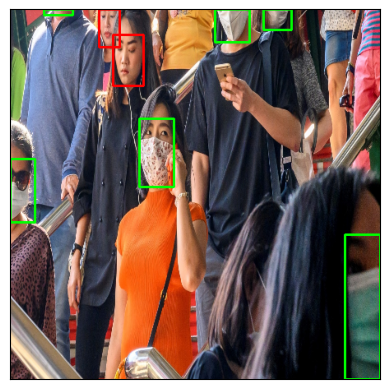

In [ ]:


label_lst = ['NG','OK']

train_transform = A.Compose([
    A.RandomSizedBBoxSafeCrop(width=450,height=450,erosion_rate=0.8),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='yolo', # Specify input format
                           label_fields=['class_labels'] # Specify label argument name(s)
                           ))

augmented = train_transform(image=image,bboxes=boxes,class_labels=label)

img = augmented['image']
result_label = augmented['class_labels']

print(img.dtype)
for i, box in enumerate(augmented['bboxes']):
    x_center, y_center, w, h = box
    x1 = int((x_center - w/2) * 450)
    y1 = int((y_center - h/2) * 450)
    x2 = int((x_center + w/2) * 450)
    y2 = int((y_center + h/2) * 450)
    if result_label[i] == 1:
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
    else:
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
plt.imshow(img)
plt.xticks([]); plt.yticks([])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


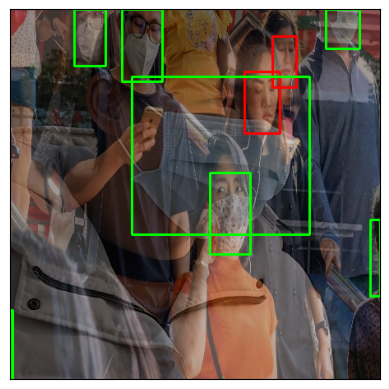

In [ ]:
import numpy as np
class MixUp:
    def __init__(self, alpha=0.7, prob=0.5):
        self.alpha = alpha
        self.prob = prob

    def __call__(self, datsset1, dataset2):
        img1 = np.array(datsset1['image']) / 255
        img2 = np.array(dataset2['image']) / 255
        mixed_img = (self.alpha * img1 + (1-self.alpha) * img2)
        mixed_boxes = datsset1['bboxes'] + dataset2['bboxes'] 
        mixed_labels = datsset1['class_labels'] + dataset2['class_labels']

        return mixed_img, mixed_boxes, mixed_labels

image_A,boxes_A,label_A=image_test[0]
image_B,boxes_B,label_B=image_test[100]
augmentedA = train_transform(image=image_A,bboxes=boxes_A,class_labels=label_A)
augmentedB = train_transform(image=image_B,bboxes=boxes_B,class_labels=label_B)

aug2 = MixUp(alpha=0.5, prob=1)
m_1,m_2,m_3 = aug2(augmentedA,augmentedB)

img = m_1
result_label = m_3

for i, box in enumerate(m_2):
    x_center, y_center, w, h = box
    x1 = int((x_center - w/2) * 450)
    y1 = int((y_center - h/2) * 450)
    x2 = int((x_center + w/2) * 450)
    y2 = int((y_center + h/2) * 450)
    if result_label[i] == 1:
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
    else:
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
plt.imshow(img)
plt.xticks([]); plt.yticks([])
plt.show()

(450, 450, 3)


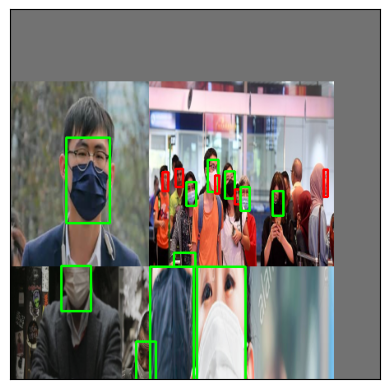

In [ ]:
import numpy as np

def apply_transform(transform, dataset, indices):
    """
    transform: Albumentations transform 객체 (예: train_transform)
    dataset: [(image, boxes, labels), ...] 형태의 리스트 or 커스텀 Dataset
    indices: 4개의 인덱스를 가진 리스트 (예: [0, 100, 10, 75])

    return: list of transformed outputs [(image, boxes, labels), ...]
    """
    results = []
    for idx in indices:
        image, boxes, labels = dataset[idx]
        augmented = transform(image=image, bboxes=boxes, class_labels=labels)
        results.append((augmented['image'], augmented['bboxes'], augmented['class_labels']))
    return results

augmented_outputs = apply_transform(train_transform,image_test,[10,20,30,40])
images = [out[0] for out in augmented_outputs]
bboxes = [out[1] for out in augmented_outputs]
labels = [out[2] for out in augmented_outputs]

Mosic_test = dataset.SimpleMosaic(225,True)
m_1,m_2,m_3 = Mosic_test(image=images, bboxes=bboxes, class_labels=labels)

img = m_1
result_label = m_3

print(img.shape)

for i, box in enumerate(m_2):
    x_center, y_center, w, h = box
    x1 = int((x_center - w/2) * 450)
    y1 = int((y_center - h/2) * 450)
    x2 = int((x_center + w/2) * 450)
    y2 = int((y_center + h/2) * 450)
    if result_label[i] == 1:
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
    else:
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
plt.imshow(img)
plt.xticks([]); plt.yticks([])
plt.show()

318
0 132
size of image x, y= 318, 318


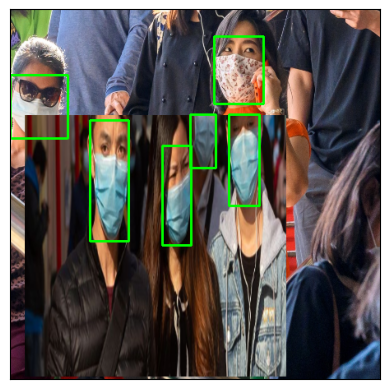

In [ ]:
import numpy as np
importlib.reload(dataset)

image_A,boxes_A,label_A=image_test[0]
image_B,boxes_B,label_B=image_test[99]
augmentedA = train_transform(image=image_A,bboxes=boxes_A,class_labels=label_A)
augmentedB = train_transform(image=image_B,bboxes=boxes_B,class_labels=label_B)

aug2 = dataset.Cutmix(lamda=0.5, prob=1)
m_1,m_2,m_3 = aug2(augmentedA,augmentedB)

img = m_1
result_label = m_3

for i, box in enumerate(m_2):
    x_center, y_center, w, h = box
    x1 = int((x_center - w/2) * 450)
    y1 = int((y_center - h/2) * 450)
    x2 = int((x_center + w/2) * 450)
    y2 = int((y_center + h/2) * 450)
    if result_label[i] == 1:
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
    else:
        cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
plt.imshow(img)
plt.xticks([]); plt.yticks([])
plt.show()

(450, 450, 3)
[[0.3152609169483185, 0.6408736109733582, 0.042169034481048584, 0.07539737224578857]]
[1.0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


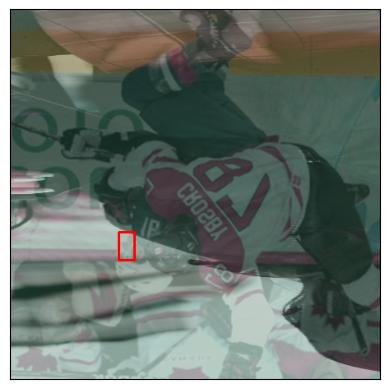